In [53]:
from typing import Callable
from itertools import pairwise

import numpy as np
from numpy import ndarray

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from scipy.optimize import rosen, rosen_der, rosen_hess,minimize, approx_fprime, approx_fprime


import doctest

# define a 2-variable function
def my_func(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

# define the point at which to compute the Hessian
x0 = np.array([1, 1])

# compute the Hessian using the approx_fprime function
H = approx_fprime(x0, lambda x: approx_fprime(x, my_func, epsilon=1e-6), epsilon=1e-6)

print(H)

def one_function(x):
    return x[0]**4-x[0]**2+x[1]**2

def done_function(x):
    return np.array([4*x[0]**3-2*x[0],2*x[1]])

[[-25.94902071   8.04334377]
 [  8.04334377  -9.9475983 ]]


# Solving linear systems

Solving linear problems of the form $\mathbf{Ax}=\mathbf{b}$ is foundational for solving non-linear problems in many dimensions.

Along the way, we also learn how to solve for determinants and inverses of matrices.

In [ ]:
def gauss_jordan_helper(matrix: ndarray) -> ndarray:
    """
    perform Gauss Jordan elimination to bring A into upper-triangular form
    changes A in place

    >>> x = np.array([[2,1,-1],[-3,-1,2],[-2,1,2]], dtype=float)
    >>> y = np.array([[2,1,-1],[0,1/2,1/2],[0,0,-1]], dtype=float)
    >>> np.allclose(y, gauss_jordan_helper(x))
    True
    """
    raise NotImplementedError
    

def gauss_jordan(matrix: ndarray) -> ndarray:
    """
    perform Gauss Jordan elimination to bring A into upper-triangular form

    >>> x = np.array([[2,1,-1],[-3,-1,2],[-2,1,2]], dtype=float)
    >>> y = np.array([[2,1,-1],[0,1/2,1/2],[0,0,-1]], dtype=float)
    >>> np.allclose(y, gauss_jordan(x))
    True
    """
    return gauss_jordan_helper(matrix.copy())


def determinant(matrix: ndarray) -> float:
    """
    get the determinant of a matrix

    >>> x = np.array([[2,1,-1],[-3,-1,2],[-2,1,2]], dtype=float)
    >>> determinant(x)
    -1.0
    """
    return np.product(np.diagonal(gauss_jordan(matrix)))


def reduced_row_echelon(matrix: ndarray) -> ndarray:
    """
    get the reduced row echelon form of an (n x m) matrix, m >= n, using Gaussian elimination


    >>> A = np.array([[2,1,-1],[-3,-1,2],[-2,1,2]], dtype=float)
    >>> np.allclose(np.eye(3), reduced_row_echelon(A))
    True
    """
    n, _ = matrix.shape

    matrix = gauss_jordan(matrix)
    matrix[:] = matrix[::-1]
    matrix[:, 0:n] = matrix[:, (n - 1)::-1]

    matrix = gauss_jordan(matrix)
    matrix[:] = matrix[::-1]
    matrix[:, 0:n] = matrix[:, (n - 1)::-1]

    matrix /= np.diagonal(matrix)[:, None]

    return matrix


def solve(matrix: ndarray, vector: ndarray) -> ndarray:
    """
    solve Ax = b for x using Gaussian elimination

    >>> m = np.array([[2,1,-1],[-3,-1,2],[-2,1,2]], dtype=float)
    >>> v = np.array([8, -11, -3], dtype=float).reshape(3,1)
    >>> x = np.array([2,3,-1], dtype=float).reshape(3,1)
    >>> np.allclose(x, solve(m, v))
    True
    """
    n, _ = matrix.shape

    aug = np.hstack([matrix, vector])
    return reduced_row_echelon(aug)[:, -1:]


def inverse(matrix: ndarray) -> ndarray:
    """
    find the inverse of square matrix A

    >>> matrix = np.array([[2,1,-1],[-3,-1,2],[-2,1,2]], dtype=float)
    >>> np.allclose(np.eye(3), matrix@inverse(matrix))
    True
    >>> matrix = np.random.rand(9).reshape(3,3)
    >>> np.allclose(np.eye(3), matrix@inverse(matrix))
    True
    """
    n, _ = matrix.shape

    aug = np.hstack([matrix, np.eye(n)])
    return reduced_row_echelon(aug)[:, n:]


doctest.testmod(verbose=False)

This approach can suffer from precision loss and divide-by-zero errors.

One solution, **pivoting**, is to rearrange the rows of the matrix to ensure that we always divide by the largest number possible.

In [ ]:
def pivot(matrix: ndarray) -> ndarray:
    """
    >>> x = np.array([[-3,2,6],[-9,1,3],[8,-5,2]], dtype=float);
    >>> pivot(x)
    array([[-9.,  1.,  3.],
           [ 8., -5.,  2.],
           [-3.,  2.,  6.]])
    """
    n, m = matrix.shape
    if n == 1:
        return matrix
    matrix[:] = matrix[[i for i, _ in sorted(zip(range(n), matrix[:, 0]), key=lambda xs: -abs(xs[1]))]]
    pivot(matrix[1:, 1:])
    return matrix

doctest.testmod(verbose=False)

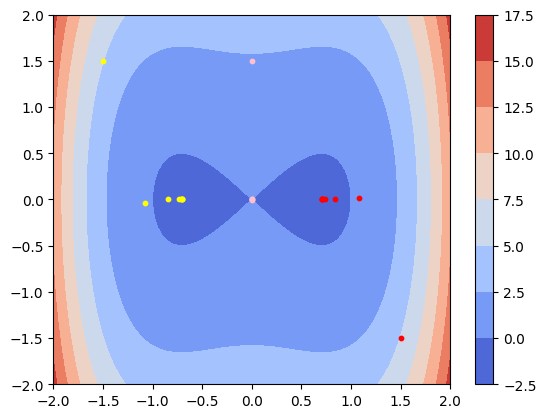

In [86]:
def newton(f,df, x0, tol):
    sequence = [x0.copy()]
    a=x0
    condition = True
    while condition:
        point=a
        b=a-df(a)@np.linalg.inv(approx_fprime(a, lambda x: approx_fprime(x, f, epsilon=tol/10), epsilon=tol/10))
        if np.linalg.norm(b-a)<=tol:
            condition=False
        sequence.append(b)
        a=b
    
    return sequence

newton(one_function,done_function,np.array([1.1,2]),1e-6)
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)

Z=one_function([X,Y])

plt.contourf(X, Y, Z, cmap='coolwarm')
plt.colorbar()

sequence1=newton(one_function,done_function,np.array([-0,1.5]),1e-6)
sequence2=newton(one_function,done_function,np.array([-1.5,1.5]),1e-6)
sequence3=newton(one_function,done_function,np.array([1.5,-1.5]),1e-6)
plt.scatter(np.array(sequence1)[:,0],np.array(sequence1)[:,1],c='pink',s=10)
plt.scatter(np.array(sequence2)[:,0],np.array(sequence2)[:,1],c='yellow',s=10)
plt.scatter(np.array(sequence3)[:,0],np.array(sequence3)[:,1],c='red',s=10)

plt.show()

In [88]:
x0 = np.array([0.5, 0.5])

sequence = newton(f=rosen, df=rosen_der, x0=x0, tol=1e-6)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8,6))


for frame, (x0, x1) in enumerate(pairwise(sequence)):
    if frame % 1 and frame > 10 and frame != len(sequence) - 1:
        continue
    print(f"drawing frame {frame}")

    simplexx = np.array([x0[0], x1[0]])
    simplexy = np.array([x0[1], x1[1]])

    if frame == 0:
        xlim, ylim = [[-4, 4], [-4, 4]]
    else:
        xlim = np.array([min(simplexx.min(), 1), max(simplexx.max(), 1)])
        xlim[0] -= (xlim[1]-xlim[0])*0.1
        xlim[1] += (xlim[1]-xlim[0])*0.1
        ylim = np.array([min(simplexy.min(), 1), max(simplexy.max(), 1)])
        ylim[0] -= (ylim[1]-ylim[0])*0.1
        ylim[1] += (ylim[1]-ylim[0])*0.1

    xs = np.linspace(*xlim, 402)
    ys = np.linspace(*ylim, 402)
    xs, ys = np.meshgrid(xs, ys)
    points = np.stack([xs, ys])
    
    ax.plot(*x0, 'ko')
    ax.plot([1],[1],'k*')
    cs = ax.contourf(
        xs, ys, rosen(points),
        cmap=plt.get_cmap("coolwarm"),
        levels=np.geomspace(1e-16,1e5,22),
        norm=LogNorm(),
        extend='both'
    )
    cbar = fig.colorbar(cs)
    cbar.ax.set_yticklabels([f'{tick:.0e}' for tick in np.geomspace(1e-16,1e5,22)])
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.annotate("", xy=x1, xytext=x0, arrowprops=dict(arrowstyle="->", linewidth=2))
    ax.set_title(f"iteration {frame}; mean $\sigma={np.linalg.norm(x1-x0):.1g}$")
    plt.savefig(f"newton.{frame:03n}.png", dpi=160)
    
    ax.cla()
    cbar.remove()
fig.clf()

drawing frame 0
drawing frame 1
drawing frame 2
drawing frame 3
drawing frame 4
drawing frame 5
drawing frame 6


<Figure size 800x600 with 0 Axes>

In [7]:
matrix=np.load("matrix.npy")
vector=np.load("vector.npy")
x=np.linalg.inv(matrix)@vector
np.linalg.norm(x)
sum(np.linalg.eigvals(matrix)<0)

500